In [1]:
import torch
import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import numpy as np
import lstm
import triplet_loss

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing = training_set.isnull().any()
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)


train_set=training_set[:10000]

seq_length = 512 
x, y = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x))
trainX=trainX[:5000]
print(trainX.shape)
size=trainX.size(0)


all training set length:  48000
torch.Size([5000, 512, 1])


In [2]:
utils.create_folder('Models/Embedder')

Directory already exists: Models/Embedder


In [3]:
sequences=utils.real_seq(training_set,seq_length)
sequences=sequences[:size]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)

float64
torch.Size([5000, 1, 512])


Train phase

In [4]:
batch_size=25
trainX=trainX.permute(0,2,1)
train = TensorDataset(trainX,sequences)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True) 
t_loss=triplet_loss.TripletLoss(None,5,0.1)
embedder=lstm.LSTMEncoder()

losses=[]
lr=0.00001
num_epochs=3
optim = Adam(embedder.parameters(), lr=lr, betas=(0.9, 0.999))

gpu = True
device=utils.assign_device(gpu)
embedder.to(device)

for epoch in range(1,num_epochs+1):
        losses_temp=[]

        for i, (X,Y) in enumerate((train_loader)):
            
            X=X.to(device)
            Y=Y.to(device)
            
            

            loss=t_loss(Y,embedder,X)
            losses_temp.append(loss)
            loss.backward()
            optim.step()
    
            
            # Print the losses
            if (i+1) % 1 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [loss: %f]"% 
                    (epoch, num_epochs, i+1, len(train_loader), loss.item()))
            
    

        losses.append(torch.mean(torch.Tensor(losses_temp)))


Cuda enabled: using GPU
[Epoch 1/3] [Batch 1/200] [loss: 0.701210]
[Epoch 1/3] [Batch 2/200] [loss: 0.700504]
[Epoch 1/3] [Batch 3/200] [loss: 0.699815]
[Epoch 1/3] [Batch 4/200] [loss: 0.699123]
[Epoch 1/3] [Batch 5/200] [loss: 0.698431]
[Epoch 1/3] [Batch 6/200] [loss: 0.697728]
[Epoch 1/3] [Batch 7/200] [loss: 0.697009]
[Epoch 1/3] [Batch 8/200] [loss: 0.696278]
[Epoch 1/3] [Batch 9/200] [loss: 0.695535]
[Epoch 1/3] [Batch 10/200] [loss: 0.694773]
[Epoch 1/3] [Batch 11/200] [loss: 0.693997]
[Epoch 1/3] [Batch 12/200] [loss: 0.693206]
[Epoch 1/3] [Batch 13/200] [loss: 0.692394]
[Epoch 1/3] [Batch 14/200] [loss: 0.691570]
[Epoch 1/3] [Batch 15/200] [loss: 0.690727]
[Epoch 1/3] [Batch 16/200] [loss: 0.689863]
[Epoch 1/3] [Batch 17/200] [loss: 0.688982]
[Epoch 1/3] [Batch 18/200] [loss: 0.688086]
[Epoch 1/3] [Batch 19/200] [loss: 0.687167]
[Epoch 1/3] [Batch 20/200] [loss: 0.686234]
[Epoch 1/3] [Batch 21/200] [loss: 0.685276]
[Epoch 1/3] [Batch 22/200] [loss: 0.684301]
[Epoch 1/3] [Batc

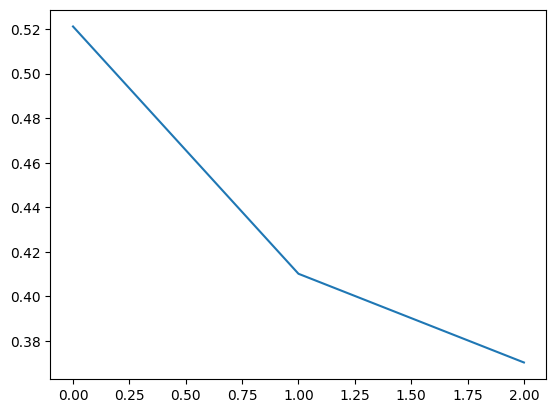

In [5]:
plt.plot(losses)

Save the Embedder Model

In [6]:
torch.save(embedder, 'Models/Embedder/embedder_model.pt')